# Part 3: Exploring and Clustering the Neighborhoods of Toronto

In [74]:
import pandas as pd
import numpy as np
import json
import geocoder
import requests
from pandas.io.json import json_normalize
import matplotlib.cm as cm
import matplotlib.colors as colors
from sklearn.cluster import KMeans
import folium
from sklearn import metrics
from scipy.spatial.distance import cdist
import matplotlib.pyplot as plt

## Load processed dataset from parts 1 and 2 of assignment

In [75]:
df = pd.read_pickle('./torontoneighborhoods.pkl')
df.head()

,Postcode,Borough,Neighbourhood,Latitude,Longitude
0,M1B,Scarborough,"Rouge, Malvern",43.811525,-79.195517
1,M1C,Scarborough,"Highland Creek, Rouge Hill, Port Union",43.785665,-79.158725
2,M1E,Scarborough,"Guildwood, Morningside, West Hill",43.765815,-79.175193
3,M1G,Scarborough,Woburn,43.768369,-79.217590
4,M1H,Scarborough,Cedarbrae,43.769688,-79.239440


## Create a map of Toronto with neighborhoods transposed on top

In [76]:
#get latitude and longitude for Toronto
g = geocoder.arcgis('Toronto, Ontario')
lat_lng_coords = g.latlng

latitude = lat_lng_coords[0]
longitude = lat_lng_coords[1]

# create foliumm map of Toronto using latitude and longitude values
map_toronto = folium.Map(location=[latitude, longitude], zoom_start=11)

# add markers to map
for lat, lng, borough, neighborhood in zip(df['Latitude'], df['Longitude'], df['Borough'], df['Neighbourhood']):
    label = '{}, {}'.format(neighborhood, borough)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_toronto)  
    
map_toronto

![alt text](https://i.imgur.com/izj1T6W.png "Map All Toronto")

## Let's just look closer at neighborhoods that are part of boroughs with Toronto in their name

In [77]:
df.Borough.unique()

array(['Scarborough', 'North York', 'East York', 'East Toronto',
       'Central Toronto', 'Downtown Toronto', 'York', 'West Toronto',
       'Mississauga', 'Etobicoke', "Queen's Park"], dtype=object)

In [78]:
t = ['East Toronto','Central Toronto','Downtown Toronto','West Toronto']
torontos = df[df.Borough.isin(t)]
torontos.head()

,Postcode,Borough,Neighbourhood,Latitude,Longitude
37,M4E,East Toronto,The Beaches,43.676531,-79.295425
41,M4K,East Toronto,"The Danforth West, Riverdale",43.683178,-79.355105
42,M4L,East Toronto,"The Beaches West, India Bazaar",43.667965,-79.314667
43,M4M,East Toronto,Studio District,43.660629,-79.334855
44,M4N,Central Toronto,Lawrence Park,43.728420,-79.387133


In [79]:
#get coordinates of Downtown Toronto
g = geocoder.arcgis('Downtown Toronto')
latlon = g.latlng

lati = g.latlng[0]
long = g.latlng[1]

# create map of just downtown Toronto using latitude and longitude values
map_dt = folium.Map(location=[lati, long], zoom_start=12)

# add markers to map
for lat, lng, label in zip(torontos['Latitude'], torontos['Longitude'], torontos['Neighbourhood']):
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_dt)  
    
map_dt

![alt text](https://i.imgur.com/fGJuZuE.png "Map Subset")

### Ok, time to start pulling information from the foursquare API to cluster the similar neighborhoods
First off, some admin stuff (hiding my credentials):

In [80]:
CLIENT_ID = 'FOCQLNFMFOSDND2KQIQQOKDJ3ZLGBBMJWX4P1O0EVZYOUX5H' # your Foursquare ID
CLIENT_SECRET = 'GTVOAKQIDEZDN5USLDMIVK1LS1CVOTZGSQYX0RCZCRBWUJOG' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version
LIMIT = 100

In [81]:
#function to get nearby venues for a given neighborhood
def getNearbyVenues(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

Let's see some of the different venues in the Toronto neighborhoods:

In [82]:
toronto_venues = getNearbyVenues(names=torontos['Neighbourhood'],
                                   latitudes=torontos['Latitude'],
                                   longitudes=torontos['Longitude']
                                  )

toronto_venues.head(10)

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,The Beaches,43.676531,-79.295425,Glen Manor Ravine,43.676821,-79.293942,Trail
1,The Beaches,43.676531,-79.295425,The Big Carrot Natural Food Market,43.678879,-79.297734,Health Food Store
2,The Beaches,43.676531,-79.295425,Grover Pub and Grub,43.679181,-79.297215,Pub
3,The Beaches,43.676531,-79.295425,Upper Beaches,43.680563,-79.292869,Neighborhood
4,"The Danforth West, Riverdale",43.683178,-79.355105,Dollarama,43.686197,-79.355989,Discount Store
5,"The Danforth West, Riverdale",43.683178,-79.355105,Charles Sauriol Parkette,43.685270,-79.356588,Park
6,"The Danforth West, Riverdale",43.683178,-79.355105,TTC Bus #8 Broadview,43.687101,-79.355078,Bus Line
7,"The Danforth West, Riverdale",43.683178,-79.355105,Sobeys,43.684723,-79.356461,Grocery Store
8,"The Beaches West, India Bazaar",43.667965,-79.314667,System Fitness,43.667171,-79.312733,Gym
9,"The Beaches West, India Bazaar",43.667965,-79.314667,Brett's Ice Cream,43.667222,-79.312831,Ice Cream Shop


Let's see how many venues are in each neighborhood:

In [83]:
toronto_venues.groupby('Neighborhood').count()

,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
Neighborhood,,,,,,
"Adelaide, King, Richmond",100,100,100,100,100,100
Berczy Park,61,61,61,61,61,61
"Brockton, Exhibition Place, Parkdale Village",68,68,68,68,68,68
Business Reply Mail Processing Centre 969 Eastern,100,100,100,100,100,100
"CN Tower, Bathurst Quay, Island airport, Harbourfront West, King and Spadina, Railway Lands, South Niagara",71,71,71,71,71,71
"Cabbagetown, St. James Town",38,38,38,38,38,38
Central Bay Street,99,99,99,99,99,99
"Chinatown, Grange Park, Kensington Market",72,72,72,72,72,72
Christie,11,11,11,11,11,11


How about how many unique categories were found:

In [84]:
print('There are {} uniques categories.'.format(len(toronto_venues['Venue Category'].unique())))

There are 220 uniques categories.


## Analyze each neighborhood
First need to understand the types of venues in each neighborhood. We'll do that using one hot encoding, and then finding different category type propensities by neighborhood.

In [85]:
# one hot encoding
toronto_onehot = pd.get_dummies(toronto_venues[['Venue Category']], prefix="", prefix_sep="")
toronto_onehot.rename(columns={"Neighborhood": "Hood"}, inplace=True) #one of the venue categories was neighborhood, which I'd like to use separately

# add neighborhood column back to dataframe
toronto_onehot['Neighborhood'] = toronto_venues['Neighborhood']

# move neighborhood column to the first column
fixed_columns = [toronto_onehot.columns[-1]] + list(toronto_onehot.columns[:-1])
toronto_onehot = toronto_onehot[fixed_columns]

toronto_onehot.head()

,Neighborhood,Adult Boutique,Afghan Restaurant,American Restaurant,Antique Shop,Art Gallery,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,BBQ Joint,...,Train Station,Tram Station,Tunnel,Vegetarian / Vegan Restaurant,Veterinarian,Video Game Store,Vietnamese Restaurant,Wine Bar,Wings Joint,Yoga Studio
0,The Beaches,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,The Beaches,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,The Beaches,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,The Beaches,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,"The Danforth West, Riverdale",0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


#### Now to find the propensities of each category in all of the neighborhoods:

In [86]:
toronto_grouped = toronto_onehot.groupby('Neighborhood').mean().reset_index()
toronto_grouped

,Neighborhood,Adult Boutique,Afghan Restaurant,American Restaurant,Antique Shop,Art Gallery,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,BBQ Joint,...,Train Station,Tram Station,Tunnel,Vegetarian / Vegan Restaurant,Veterinarian,Video Game Store,Vietnamese Restaurant,Wine Bar,Wings Joint,Yoga Studio
0,"Adelaide, King, Richmond",0.000000,0.000000,0.030000,0.000000,0.010000,0.000000,0.030000,0.000000,0.000000,...,0.000000,0.000,0.000000,0.010000,0.000000,0.000000,0.000000,0.010000,0.000000,0.000000
1,Berczy Park,0.000000,0.000000,0.000000,0.000000,0.016393,0.000000,0.000000,0.000000,0.016393,...,0.000000,0.000,0.000000,0.016393,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2,"Brockton, Exhibition Place, Parkdale Village",0.000000,0.000000,0.000000,0.000000,0.029412,0.014706,0.000000,0.000000,0.000000,...,0.000000,0.000,0.014706,0.029412,0.000000,0.000000,0.014706,0.000000,0.000000,0.000000
3,Business Reply Mail Processing Centre 969 Eastern,0.000000,0.000000,0.020000,0.000000,0.000000,0.010000,0.020000,0.000000,0.000000,...,0.000000,0.000,0.000000,0.020000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
4,"CN Tower, Bathurst Quay, Island airport, Harbo...",0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.014085,0.000000,0.000000,...,0.014085,0.000,0.000000,0.000000,0.014085,0.000000,0.000000,0.000000,0.000000,0.014085
5,"Cabbagetown, St. James Town",0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
6,Central Bay Street,0.000000,0.000000,0.010101,0.000000,0.010101,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000,0.000000,0.000000,0.000000,0.010101,0.010101,0.010101,0.000000,0.000000
7,"Chinatown, Grange Park, Kensington Market",0.000000,0.000000,0.000000,0.000000,0.041667,0.013889,0.000000,0.000000,0.000000,...,0.000000,0.000,0.000000,0.041667,0.000000,0.000000,0.041667,0.013889,0.000000,0.000000
8,Christie,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.090909,0.000000,...,0.000000,0.000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
9,Church and Wellesley,0.000000,0.012821,0.012821,0.000000,0.000000,0.012821,0.000000,0.000000,0.000000,...,0.000000,0.000,0.000000,0.000000,0.000000,0.000000,0.012821,0.000000,0.000000,0.000000


#### Now we can look at what are the top venue categories by neighborhood as a df:

In [97]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

num_top_venues = 5

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighborhood'] = toronto_grouped['Neighborhood']

for ind in np.arange(toronto_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(toronto_grouped.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted.head()

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
0,"Adelaide, King, Richmond",Coffee Shop,Café,Hotel,Steakhouse,Bar
1,Berczy Park,Coffee Shop,Cocktail Bar,Breakfast Spot,Hotel,Seafood Restaurant
2,"Brockton, Exhibition Place, Parkdale Village",Coffee Shop,Café,Restaurant,Furniture / Home Store,Bakery
3,Business Reply Mail Processing Centre 969 Eastern,Coffee Shop,Bar,Hotel,Steakhouse,Café
4,"CN Tower, Bathurst Quay, Island airport, Harbo...",Coffee Shop,Italian Restaurant,Bar,Café,Park


### We're all set to cluster the neighborhoods at this point!

I want to make sure that I use the best value for K (or choose the proper number of clusters).  So I'll use the elbow method, and choose from between 1 and 10 clusters:

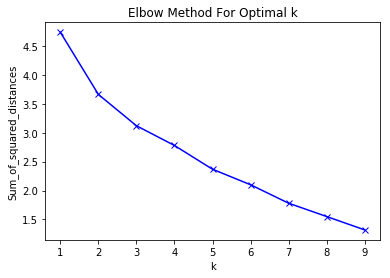

In [88]:
toronto_grouped_clustering = toronto_grouped.drop('Neighborhood', 1)

Sum_of_squared_distances = []
K = range(1,10)
for k in K:
    km = KMeans(n_clusters=k)
    km = km.fit(toronto_grouped_clustering)
    Sum_of_squared_distances.append(km.inertia_)

plt.plot(K, Sum_of_squared_distances, 'bx-')
plt.xlabel('k')
plt.ylabel('Sum_of_squared_distances')
plt.title('Elbow Method For Optimal k')
plt.show()

This is an imperfect science, but I think it's fair to say that there is an elbow at 3 and 5 clusters.  I'll use 3.

In [96]:
# set number of clusters
kclusters = 3

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(toronto_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 2, 1, 0,
       0, 2, 2, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2])

In [98]:
# add clustering labels
neighborhoods_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

toronto_merged = torontos
toronto_merged.rename(columns={'Neighbourhood': 'Neighborhood'}, inplace=True)

# merge toronto_grouped with toronto_data to add latitude/longitude for each neighborhood
toronto_merged = toronto_merged.join(neighborhoods_venues_sorted.set_index('Neighborhood'), on='Neighborhood')

toronto_merged.head(10)

,Postcode,Borough,Neighborhood,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
37,M4E,East Toronto,The Beaches,43.676531,-79.295425,0,Health Food Store,Pub,Trail,Hood,Eastern European Restaurant
41,M4K,East Toronto,"The Danforth West, Riverdale",43.683178,-79.355105,2,Bus Line,Grocery Store,Park,Discount Store,Yoga Studio
42,M4L,East Toronto,"The Beaches West, India Bazaar",43.667965,-79.314667,0,Park,Gym,Movie Theater,Fast Food Restaurant,Burrito Place
43,M4M,East Toronto,Studio District,43.660629,-79.334855,0,Diner,Café,Italian Restaurant,Brewery,Sandwich Place
44,M4N,Central Toronto,Lawrence Park,43.728420,-79.387133,0,Bus Line,Swim School,Lake,Yoga Studio,Ethiopian Restaurant
45,M4P,Central Toronto,Davisville North,43.712755,-79.388514,0,Food & Drink Shop,Gym,Park,Department Store,Hotel
46,M4R,Central Toronto,North Toronto West,43.714523,-79.406960,2,Playground,Gym Pool,Park,Garden,Yoga Studio
47,M4S,Central Toronto,Davisville,43.703395,-79.385964,0,Dessert Shop,Café,Sandwich Place,Pizza Place,Italian Restaurant
48,M4T,Central Toronto,"Moore Park, Summerhill East",43.690685,-79.382946,2,Playground,Gym,Park,Tennis Court,Donut Shop
49,M4V,Central Toronto,"Deer Park, Forest Hill SE, Rathnelly, South Hi...",43.686074,-79.402265,0,Light Rail Station,Coffee Shop,Liquor Store,Supermarket,Yoga Studio


### Finally let's visualize the clusters:

In [99]:
# create map
map_clusters = folium.Map(location=[lati, long], zoom_start=12)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(toronto_merged['Latitude'], toronto_merged['Longitude'], toronto_merged['Neighborhood'], toronto_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

![alt text](https://i.imgur.com/VlDWETA.png 'Clusters Map')

### Let's take a look at the cluster members and see if there are defining characteristics:

##### Cluster 1

In [100]:
toronto_merged.loc[toronto_merged['Cluster Labels'] == 0, toronto_merged.columns[[1] + list(range(5, toronto_merged.shape[1]))]]

,Borough,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
37,East Toronto,0,Health Food Store,Pub,Trail,Hood,Eastern European Restaurant
42,East Toronto,0,Park,Gym,Movie Theater,Fast Food Restaurant,Burrito Place
43,East Toronto,0,Diner,Café,Italian Restaurant,Brewery,Sandwich Place
44,Central Toronto,0,Bus Line,Swim School,Lake,Yoga Studio,Ethiopian Restaurant
45,Central Toronto,0,Food & Drink Shop,Gym,Park,Department Store,Hotel
47,Central Toronto,0,Dessert Shop,Café,Sandwich Place,Pizza Place,Italian Restaurant
49,Central Toronto,0,Light Rail Station,Coffee Shop,Liquor Store,Supermarket,Yoga Studio
51,Downtown Toronto,0,Restaurant,Coffee Shop,Pizza Place,Italian Restaurant,Café
52,Downtown Toronto,0,Coffee Shop,Japanese Restaurant,Gay Bar,Restaurant,Sushi Restaurant
53,Downtown Toronto,0,Coffee Shop,Bakery,Café,Theater,Boat or Ferry


Cluster 1 is dominated by coffee shops, cafes, and different types of restaurants.  It's not surprising that many of the neighborhoods around a city center might be similar in this manner.

##### Cluster 2

In [101]:
toronto_merged.loc[toronto_merged['Cluster Labels'] == 1, toronto_merged.columns[[1] + list(range(5, toronto_merged.shape[1]))]]

,Borough,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
64,Central Toronto,1,Park,Yoga Studio,Dumpling Restaurant,Flea Market,Fish Market
82,West Toronto,1,Sandwich Place,Park,Dumpling Restaurant,Flea Market,Fish Market


##### Cluster 3

In [102]:
toronto_merged.loc[toronto_merged['Cluster Labels'] == 2, toronto_merged.columns[[1] + list(range(5, toronto_merged.shape[1]))]]

,Borough,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
41,East Toronto,2,Bus Line,Grocery Store,Park,Discount Store,Yoga Studio
46,Central Toronto,2,Playground,Gym Pool,Park,Garden,Yoga Studio
48,Central Toronto,2,Playground,Gym,Park,Tennis Court,Donut Shop
50,Downtown Toronto,2,Playground,Grocery Store,Candy Store,Park,Eastern European Restaurant
59,Downtown Toronto,2,Harbor / Marina,Pier,Park,Yoga Studio,Eastern European Restaurant


Cluster 3 appears to be more public spaces like parks, playgrounds, and the harbor/marina.